# Building a Startup Pitch Evaluator using CrewAI and Langfuse
Agents in this notebook assess startup ideas, check market trends, and generate investor feedback.

## Setup Instructions

Before starting, install the required packages.

In [ ]:
# === STEP 1: Install Dependencies ===
!pip install crewai duckduckgo-search --quiet
!pip install "langfuse<3.0.0"
!pip install openai groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
# === STEP 2: Imports ===
from crewai import Agent, Task, Crew
from duckduckgo_search import DDGS
import os
from langfuse import Langfuse
from groq import Groq

In [ ]:
# === STEP 3: Access Colab Secrets for Environment Variables ===
from google.colab import userdata

os.environ["LANGFUSE_PUBLIC_KEY"] = userdata.get("Langfuse_public")
os.environ["LANGFUSE_SECRET_KEY"] = userdata.get("Langfuse_secret")
os.environ["GROQ_API_KEY"] = userdata.get("groqkey")

In [ ]:
# === STEP 4: Initialize Langfuse ===
langfuse = Langfuse(
    public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
    secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
    release="v1",
)

In [ ]:
# === STEP 5: Define Tools ===
from duckduckgo_search import DDGS

def get_market_trends(query, max_results=5):
    """Fetch real-time market trends using DuckDuckGo."""
    results = []
    with DDGS() as ddgs:
        search_results = ddgs.text(query, max_results=max_results)
        for r in search_results:
            title = r.get("title", "No Title")
            href = r.get("href", "No Link")
            snippet = r.get("body", "")
            results.append(f"{title} - {href}\n  ↳ {snippet}")
    return results

def simulate_investor_feedback(pitch, trends):
    """Generate realistic investor feedback using GPT-4o-mini."""
    prompt = f"""You're an investor evaluating a startup pitch.

Startup Pitch:
{pitch}

Relevant Market Trends:
{chr(10).join('- ' + trend for trend in trends)}

Please provide investor-style feedback highlighting strengths, concerns, and potential questions."""


    client = Groq()

    response = client.chat.completions.create(
        model="meta-llama/llama-4-scout-17b-16e-instruct",
        messages=[
            {"role": "system", "content": "You are a sharp, professional early-stage investor."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
    )

    return response.choices[0].message.content

In [ ]:
# === STEP 6: Define Agents ===
# --- Agent 1: Market Analyst ---
from langfuse.decorators import langfuse_context, observe

class MarketAnalystAgent(Agent):
    def __init__(self):
        super().__init__(
            name="Market Analyst",
            role="Market Researcher",
            goal="Identify relevant market trends for the startup's domain.",
            backstory="You are a data-driven analyst skilled in identifying market opportunities and trends."
        )

    @observe()
    def run(self, task_input):
        trends = get_market_trends(task_input)
        return trends

# --- Agent 2: Pitch Evaluator ---
class PitchEvaluatorAgent(Agent):
    def __init__(self):
        super().__init__(
            name="Pitch Evaluator",
            role="Investor Feedback Analyst",
            goal="Evaluate the pitch using market insights and provide detailed feedback.",
            backstory="You are a seasoned investor who evaluates startup pitches and provides insightful, constructive feedback."
        )

    @observe()
    def run(self, task_input):
        pitch, trends = task_input["pitch"], task_input["trends"]
        feedback = simulate_investor_feedback(pitch, trends)
        return feedback


In [ ]:
# === STEP 7: Define Task and Crew ===
pitch_text = """
Outlandish is a premium handcrafted soap brand rooted in clean beauty and sustainability. Our products are made from 100% natural ingredients—free of synthetic chemicals, parabens, and artificial fragrances. Every bar is cold-processed and packaged using biodegradable, plastic-free materials.
We’re targeting the fast-growing conscious consumer segment by offering skincare that’s luxurious, eco-friendly, and transparently sourced. With a strong visual identity, artisanal appeal, and a focus on skin nourishment, Outlandish aims to disrupt the mass-produced soap market with authenticity and quality.
Our go-to-market strategy focuses on D2C channels, influencer partnerships, and retail placements in organic lifestyle stores. We’re positioned at the intersection of beauty, wellness, and sustainability—offering a product that’s better for your skin and better for the planet.
"""

analyst = MarketAnalystAgent()
evaluator = PitchEvaluatorAgent()

# Define task for Market Analyst
task1 = Task(description="Research trends in the natural skincare and clean beauty market for 2025", expected_output_type=str, expected_output="")
# Define task for Pitch Evaluator
task2 = Task(description="natural skincare and clean beauty market 2025", expected_output_type=str, expected_output="")

# Crew Execution (manual orchestration)
print("[+] Running Market Analyst Agent...")
trends = analyst.run("Premium sustainable handcrafted soap markets in 2025")
print("\n[+] Trends Identified:\n", "\n".join(trends))

print("\n[+] Running Pitch Evaluator Agent...")
feedback = evaluator.run({"pitch": pitch_text, "trends": trends})
print("\n[Investor Feedback]\n", feedback)

[+] Running Market Analyst Agent...

[+] Trends Identified:
 Handmade Soap Market Trends & Forecast 2033 - https://www.globalgrowthinsights.com/market-reports/handmade-soap-market-114928
  ↳ Global Handmade Soap Market size is projected to grow from USD 188.8 Million in 2025 to USD 299.56 Million by 2033, expanding at a CAGR of 5.94%. ... 41% of brands now offer customized handmade soap; 45% adopt sustainable practices influencing global buying behavior. ... The increasing use of social media has influenced 31% of urban consumers ...
Handmade Soap Market Size, Trends | Report [2032] - https://www.businessresearchinsights.com/market-reports/handmade-soap-market-117948
  ↳ global Handmade Soap market size valued at USD 0.17 billion in 2024, is expected to reach USD 0.29 billion by 2032, at a CAGR of 6.64% ... Rising recognition about skin health and environmental effect helps the boom of premium, handmade soap brands in the location. ... and Dr. Bronner's, a frontrunner in natural and tr

# **Market Analyst Langfuse SS**

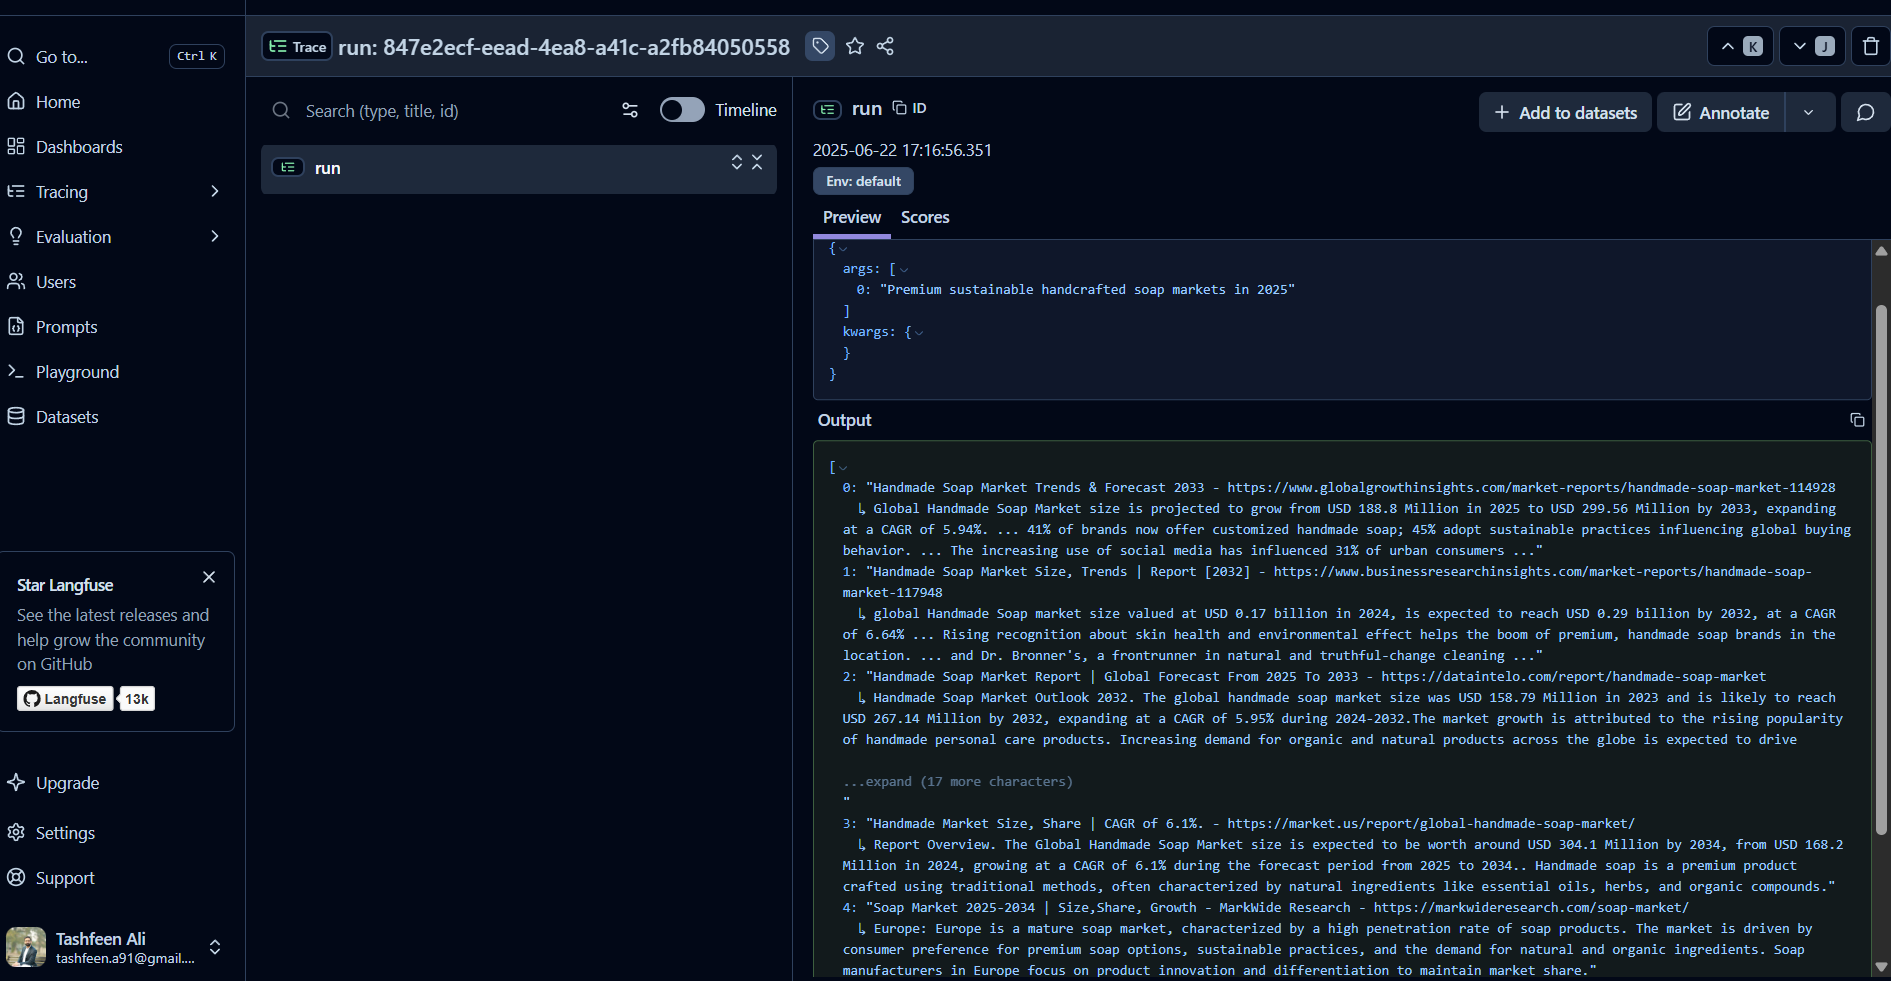

# **Pitch Evaluator SS**

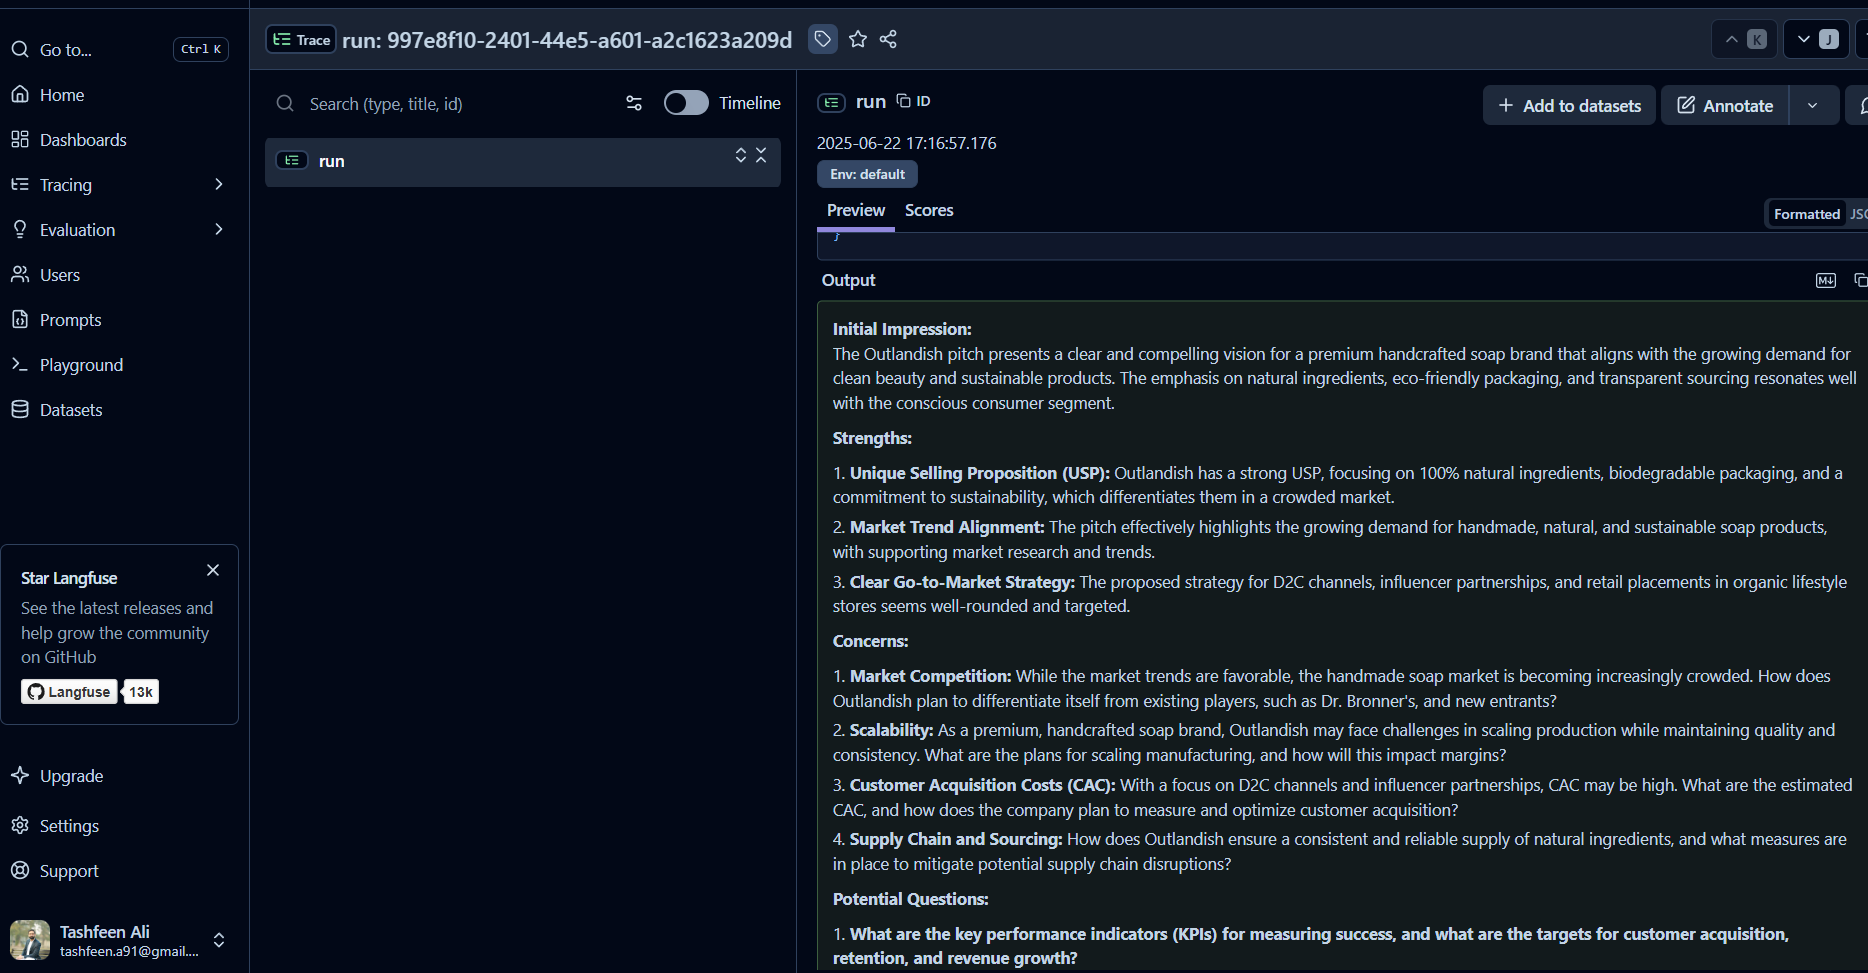